# CNN

## Utilisation de Jupyter Notebook

Le principe est simple : 
 - Chaque notebook est constitué d’une liste de **cellules**
 - Chacune peut contenir du **texte formaté** ou du **code** (Python, dans notre cas)
 - On **exécute** une cellule de code -> le résultat s’affiche sous la cellule

Cliquez sur le menu **Help** > **User Interface Tour** pour un tour rapide de l’interface.    

Pour vous entraîner :
- **Insérez** quelques cellules de code au début du notebook
- Exécutez quelques commandes Python, telles que **print("Hello world!")** :
    - Cliquez dans une cellule de code et saisissez le code à exécuter
    - Exécutez le code de la cellule en tapant Shift-Entrée ou en cliquant sur le bouton d’exécution
    
Lorsque vous **cliquez** à l’intérieur d’une cellule, vous passez en mode **édition** (la cellule est alors encadrée en *vert*). Lorsque vous tapez la **touche Echap** (Esc) ou que vous cliquez juste à gauche de la cellule, vous passez en mode **commande** (la cellule est alors encadrée en *bleu*). 

Lorsque vous êtes en **mode commande**, tapez la **touche H** pour afficher les nombreux **raccourcis clavier** disponibles

## Préparation

Tout d'abord, assurons-nous que ce bloc-notes fonctionne bien en python 3, importons quelques modules communs, assurons-nous que MatplotLib trace des figures :

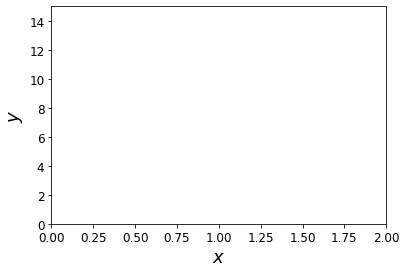

In [11]:
# Pour soutenir à la fois python 2 et python 3
from __future__ import division, print_function, unicode_literals

# Importations communes
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Pour que la production soit stable d'un bout à l'autre
np.random.seed(42)

# Pour tracer de jolis figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=90, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Quelques fonctions pour afficher des images à niveaux de gris ou en couleur :

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

Pour utiliser TensorFlow :

In [13]:
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Pour utiliser d'autres utilitaires :

In [14]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# La couche de convolution

Le code ci-dessous permet d'appliquer un **filtre de convolution** *vertical* et *horizontal* sur une image exemple :

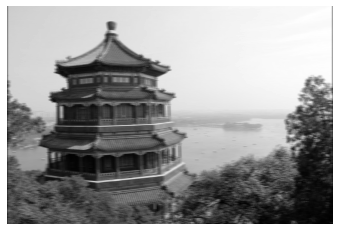

In [15]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

L'image originale peut être affichée comme ci-dessous :

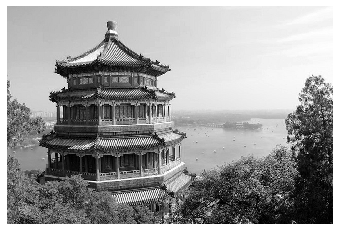

In [16]:
plot_image(images[0, :, :, 0])
plt.show()

L'application du filtre vertical donne ceci :

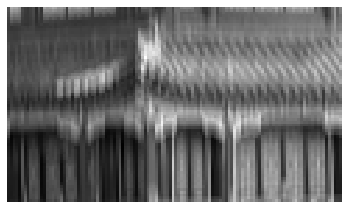

In [17]:
plot_image(crop(outputs[0, :, :,0]))
plt.show()

L'application du filtre horizontal donne ceci :

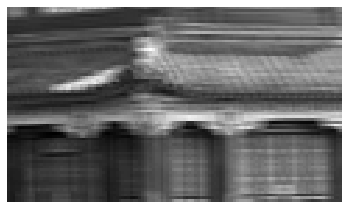

In [18]:
plot_image(crop(outputs[0, :, :,1]))
plt.show()

**Question 1.1 :** Afficher dessous votre propre image et le résultat du filtre horizontal. 

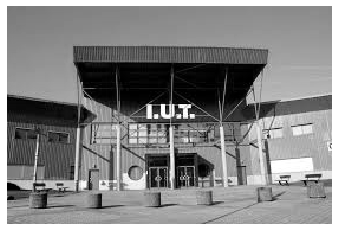

In [19]:
# Reponse
from PIL import Image

img = np.array(Image.open('monImage.jpg'))
height, width, channels = img.shape
image_grayscale = img.mean(axis=2).astype(np.float32)
monImages = image_grayscale.reshape(1, height, width, 1)
plot_image(monImages[0, :, :, 0])
plt.show()

**Question 1.2 :** Quelle partie de l'image ce filtre met-il en évidence ?

réponse

Le code ci-dessous applique les **2** filtres sur la même image :

In [20]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [21]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [22]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [23]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [24]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

Image de départ :

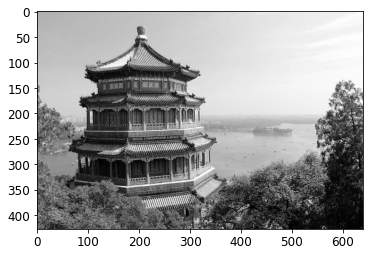

In [25]:
plt.imshow(images[0, :, :, 0], cmap="gray")

Image résultante :

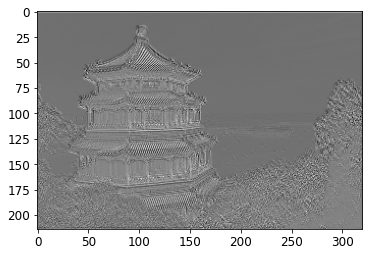

In [26]:
same_output[0, :, :,0].shape
plt.imshow(same_output [0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
#plt.show() 

**Question 1.3** Faire la même chose avec une image à vous

In [27]:
# Reponse
    

**Question 1.4** : Que représente ce résultat, qu'est-ce qui est mis en valeur ?

reponse

# Couche de pooling

Le code ci-dessous permet d'extraire une couche de **pooling** ([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) d'une image :

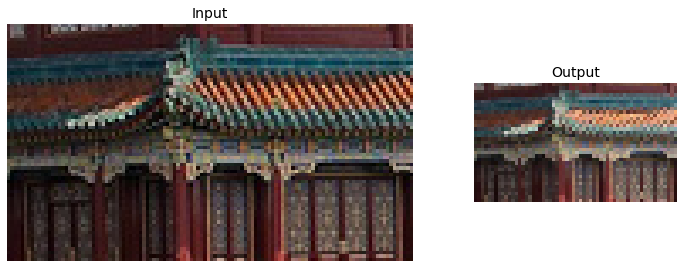

In [28]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Question 2.1 :** Modifier le code ci-dessous pour faire une couche de pooling de taille 8x8.

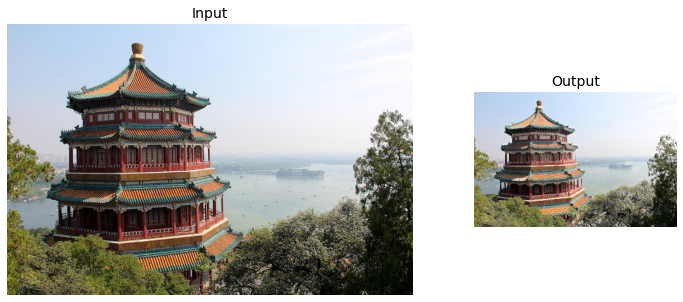

In [29]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
my_images = np.array([image for image in images], dtype=np.float32)
output = max_pool(my_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show() 

**Question 2.2 :** Est-ce qu'il y a de la perte d'information ? Cela va-t-il favoriser le surajustement ?

Réponse

**Question 2.3 :** Modifier le code ci-dessous pour faire pour créer une couche de mean-pooling qui utilise la moyenne plutôt que le maximum

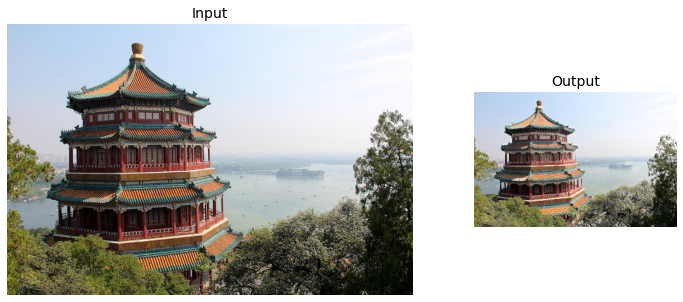

In [30]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
my_images = np.array([image for image in images], dtype=np.float32)
output = max_pool(my_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show() 

**Question 2.4** Est-ce que l'image est plus clair ou plus sombre qu'avec le maximum ? Expliquer pourquoi

# Utilisation de CNN

Le fichier [model](model.h5) contient les poids d'un réseau CNN appris à l'aide de la base disponible [ici](https://www.kaggle.com/c/dogs-vs-cats/data) et du programme [learnCat.py](learnCat.py)

![](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/05/Cats-Dogs-Classification-deep-learning.gif)

Pour charger le modèle, utiliser : 

In [31]:
# Keras - high-level API for TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator



###########################
#  Définition du CNN      #
###########################

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


###################################
#  Chargement des poids entraînés #
###################################

model.load_weights('model.h5');

In [32]:
def predict_class(fichier):
    #import image 
    image=plt.imread(fichier)
    plot_image(image)
    #preprocess image
    image=np.array(image)
    image=image.astype("float32")/255
    #predict
    img_size = 150
    inference=model.predict((tf.expand_dims(tf.image.resize(image,(img_size,img_size)),axis=0)))
    predicted_class_indices = np.round(inference)
    print(predicted_class_indices)

Pour tester, une image :

[[1.]]


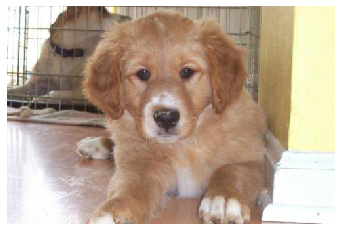

In [34]:
predict_class('dog.jpg')

**Question 3** Faire des expériences avec plusieurs images d'internet et faire en compte rendu ci-dessous